<a href="https://colab.research.google.com/github/deep-diver/auto-paper-analysis/blob/main/notebooks/analyze_arxiv_pdf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import HTML, display
from IPython.display import Markdown

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [2]:
!pip install google-generativeai
!pip install pypdf2
!pip install fitz
!pip install pymupdf

In [2]:
GEMINI_API_KEY="..."

In [3]:
import requests

def download_pdf_from_arxiv(arxiv_id):
  url = f'http://export.arxiv.org/pdf/{arxiv_id}'
  response = requests.get(url)
  if response.status_code == 200:
    return response.content
  else:
    raise Exception(f"Failed to download pdf for arXiv id {arxiv_id}")

# Example usage
arxiv_id = "2402.12226"
pdf_content = download_pdf_from_arxiv(arxiv_id)

# Save the pdf content to a file
with open(f"{arxiv_id}.pdf", "wb") as f:
  f.write(pdf_content)


In [4]:
import fitz  # PyMuPDF
import PyPDF2

def extract_text_and_figures(pdf_path):
    """
    Extracts text and figures from a PDF file.

    Args:
        pdf_path (str): The path to the PDF file.

    Returns:
        tuple: A tuple containing two lists:
            * A list of extracted text blocks.
            * A list of extracted figures (as bytes).
    """

    texts = []
    figures = []

    # Open the PDF using PyMuPDF (fitz) for image extraction
    doc = fitz.open(pdf_path)
    for page_num, page in enumerate(doc):
        text = page.get_text("text")  # Extract text as plain text
        texts.append(text)

        # Process images on the page
        image_list = page.get_images()
        for image_index, img in enumerate(image_list):
            xref = img[0]  # Image XREF
            pix = fitz.Pixmap(doc, xref)  # Create Pixmap image

            # Save image in desired format (here, PNG)
            if pix.n < 5:  # Grayscale or RGB
                img_bytes = pix.tobytes("png")
            else:  # CMYK: Convert to RGB first
                pix = fitz.Pixmap(fitz.csRGB, pix)
                img_bytes = pix.tobytes("png")

            figures.append(img_bytes)

    # Extract additional text using PyPDF2 (in case fitz didn't get everything)
    with open(pdf_path, 'rb') as pdf_file:
        pdf_reader = PyPDF2.PdfReader(pdf_file)
        for page_num in range(len(pdf_reader.pages)):
            page = pdf_reader.pages[page_num]
            text = page.extract_text()
            texts.append(text)

    return texts, figures


In [5]:
texts, figures = extract_text_and_figures(f'{arxiv_id}.pdf')

In [6]:
texts[0]

'AnyGPT: Unified Multimodal LLM with Discrete Sequence Modeling\nJun Zhan1,*, Junqi Dai1,*, Jiasheng Ye1,*\nYunhua Zhou1, Dong Zhang1, Zhigeng Liu1, Xin Zhang1\nRuibin Yuan2, Ge Zhang2, Linyang Li1, Hang Yan3, Jie Fu2\nTao Gui1, Tianxiang Sun1, Yugang Jiang1, Xipeng Qiu1,†\n1Fudan University\n2 Multimodal Art Projection Research Community\n3Shanghai AI Laboratory\nAbstract\nWe introduce AnyGPT, an any-to-any multi-\nmodal language model that utilizes discrete\nrepresentations for the unified processing of\nvarious modalities, including speech, text,\nimages, and music. AnyGPT can be trained\nstably without any alterations to the current\nlarge language model (LLM) architecture\nor training paradigms.\nInstead, it relies\nexclusively\non\ndata-level\npreprocessing,\nfacilitating the seamless integration of new\nmodalities into LLMs, akin to the incorporation\nof new languages.\nWe build a multimodal\ntext-centric dataset for multimodal alignment\npre-training.\nUtilizing generative mode

In [8]:
print(len(figures))
print(type(figures[0]))

93
<class 'bytes'>


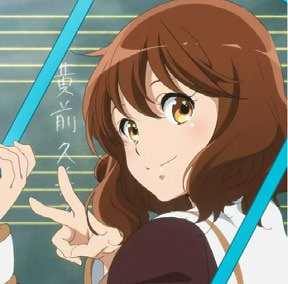

In [9]:
import io
from PIL import Image

img = Image.open(io.BytesIO(figures[0]))
display(img)

In [50]:
def determine_model_name(given_image=None):
  if given_image is None:
    return "gemini-pro"
  else:
    return "gemini-pro-vision"

def construct_image_part(given_image):
  return {
    "mime_type": "image/jpeg",
    "data": given_image
  }

def construct_blog_part(given_blob, mime_type="pdf/application"):
  return {
      "mime_type": mime_type,
      "data": given_blob
  }

def call_gemini(prompt="", API_KEY=None, given_text=None, given_image=None, given_blob=None, generation_config=None, safety_settings=None):
  import google.generativeai as genai
  genai.configure(api_key=API_KEY)

  if generation_config is None:
    generation_config = {
      "temperature": 0.8,
      "top_p": 1,
      "top_k": 32,
      "max_output_tokens": 8192,
    }

  if safety_settings is None:
    safety_settings = [
      {
        "category": "HARM_CATEGORY_HARASSMENT",
        "threshold": "BLOCK_ONLY_HIGH"
      },
      {
        "category": "HARM_CATEGORY_HATE_SPEECH",
        "threshold": "BLOCK_ONLY_HIGH"
      },
      {
        "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
        "threshold": "BLOCK_ONLY_HIGH"
      },
      {
        "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
        "threshold": "BLOCK_ONLY_HIGH"
      },
    ]

  model_name = determine_model_name(given_image)
  model = genai.GenerativeModel(model_name=model_name,
                                generation_config=generation_config,
                                safety_settings=safety_settings)

  USER_PROMPT = prompt
  if given_text is not None:
    USER_PROMPT += f"""{prompt}
  ------------------------------------------------
  {given_text}
  """
  prompt_parts = [USER_PROMPT]
  if given_image is not None:
    prompt_parts.append(construct_image_part(given_image))
  if given_blob is not None:
    prompt_parts.append(construct_blog_part(given_blob))

  response = model.generate_content(prompt_parts)
  return response.text

In [51]:
import json

def find_json_snippet(raw_snippet):
	json_parsed_string = None

	json_start_index = raw_snippet.find('{')
	json_end_index = raw_snippet.rfind('}')

	if json_start_index >= 0 and json_end_index >= 0:
		json_snippet = raw_snippet[json_start_index:json_end_index+1]
		try:
			json_parsed_string = json.loads(json_snippet, strict=False)
		except:
			raise ValueError('failed to parse string into JSON format')
	else:
		raise ValueError('No JSON code snippet found in string.')

	return json_parsed_string

def parse_first_json_snippet(snippet):
	json_parsed_string = None

	if isinstance(snippet, list):
		for snippet_piece in snippet:
			try:
				json_parsed_string = find_json_snippet(snippet_piece)
				return json_parsed_string
			except:
				pass
	else:
		try:
			json_parsed_string = find_json_snippet(snippet)
		except Exception as e:
			print(e)
			raise ValueError()

	return json_parsed_string

In [52]:
text =' '.join(texts)

In [53]:
prompt = """
come up with the 10 questions and answers that could be commonly asked by people about the following paper.
There should be two types of answers included, one for expert and the other for ELI5.
Your response should be recorded in a JSON format as ```json{"title": text, "summary": text, "qna": [{"question": "answers": {"eli5": text, "expert": text}}, ...]}```
"""

In [54]:
qna_json = None
cur_retry = 0
retry_num = 5

while qna_json is None and cur_retry < retry_num:
  try:
    qna = call_gemini(
        prompt=prompt,
        given_text=text[:7000],
        API_KEY=GEMINI_API_KEY
    )

    qna_json = parse_first_json_snippet(qna)
  except:
    cur_retry = cur_retry + 1
    print("retry")

In [55]:
qna_json

{'title': 'AnyGPT: Unified Multimodal LLM with Discrete Sequence Modeling',
 'summary': 'AnyGPT is a unified multimodal language model that can process and generate text, images, music, and speech using discrete representations. It is trained on a new multimodal alignment dataset and a synthesized multimodal instruction dataset, enabling it to handle arbitrary combinations of multimodal inputs and outputs.',
 'qna': [{'question': 'What is AnyGPT?',
   'answers': {'eli5': 'AnyGPT is a computer program that can understand and generate different types of information, such as text, images, music, and speech.',
    'expert': 'AnyGPT is a unified multimodal language model that employs discrete representations for unified processing of various modalities, including speech, text, images, and music.'}},
  {'question': 'How does AnyGPT work?',
   'answers': {'eli5': 'AnyGPT uses special codes to convert different types of information into a format that it can understand. Then, it processes and g

In [56]:
qna_json['summary']

'AnyGPT is a unified multimodal language model that can process and generate text, images, music, and speech using discrete representations. It is trained on a new multimodal alignment dataset and a synthesized multimodal instruction dataset, enabling it to handle arbitrary combinations of multimodal inputs and outputs.'

In [57]:
qna_json['qna']

[{'question': 'What is AnyGPT?',
  'answers': {'eli5': 'AnyGPT is a computer program that can understand and generate different types of information, such as text, images, music, and speech.',
   'expert': 'AnyGPT is a unified multimodal language model that employs discrete representations for unified processing of various modalities, including speech, text, images, and music.'}},
 {'question': 'How does AnyGPT work?',
  'answers': {'eli5': 'AnyGPT uses special codes to convert different types of information into a format that it can understand. Then, it processes and generates the information using these codes.',
   'expert': 'AnyGPT utilizes multimodal tokenizers to compress raw multimodal data into a sequence of discrete semantic tokens. These tokens are processed by the core LLM autoregressively, and de-tokenizers convert the discrete representations back into the original modal representations.'}},
 {'question': 'What are the benefits of using discrete representations?',
  'answer

In [58]:
fig0_desc = call_gemini(
    prompt=f'Below is the summary of the academic paper, {qna_json["title"]}. '
           'Based on the summary, give me the description of the given figure. '
           'Give me your response by filling in the following JSON. '
           '{"description": text}',
    given_text=qna_json['summary'],
    given_image=figures[0],
    API_KEY=GEMINI_API_KEY
)

In [59]:
fig0_desc

' The figure shows an anime girl with brown hair and yellow eyes making a peace sign. She is standing in front of a blackboard with musical notes written on it.'

## Analyze deeper

### Title

In [60]:
Markdown(f"# {qna_json['title']}")

# AnyGPT: Unified Multimodal LLM with Discrete Sequence Modeling

### Summary

In [61]:
Markdown(f"### {qna_json['summary']}")

### AnyGPT is a unified multimodal language model that can process and generate text, images, music, and speech using discrete representations. It is trained on a new multimodal alignment dataset and a synthesized multimodal instruction dataset, enabling it to handle arbitrary combinations of multimodal inputs and outputs.

### QnAs

In [62]:
for qna in qna_json['qna']:
  q = qna['question']
  a_eli5 = qna['answers']['eli5']
  a_expert = qna['answers']['expert']

  print(f"⦿ {q}")
  print(f"-- ELI5: {a_eli5}")
  print(f"-- Expert: {a_expert}\n")

⦿ What is AnyGPT?
-- ELI5: AnyGPT is a computer program that can understand and generate different types of information, such as text, images, music, and speech.
-- Expert: AnyGPT is a unified multimodal language model that employs discrete representations for unified processing of various modalities, including speech, text, images, and music.

⦿ How does AnyGPT work?
-- ELI5: AnyGPT uses special codes to convert different types of information into a format that it can understand. Then, it processes and generates the information using these codes.
-- Expert: AnyGPT utilizes multimodal tokenizers to compress raw multimodal data into a sequence of discrete semantic tokens. These tokens are processed by the core LLM autoregressively, and de-tokenizers convert the discrete representations back into the original modal representations.

⦿ What are the benefits of using discrete representations?
-- ELI5: Discrete representations help AnyGPT to focus on the important parts of different types o

### More QnAs

In [63]:
deep_prompt = """
Paper title: %s
Previous question: %s
The answer on the previous question: %s

Based on the previous question and answer above, and based on the paper content below, suggest follow-up question and answers in %s manner.
There should be two types of answers included, one for expert and the other for ELI5.
Your response should be recorded in a JSON format as ```json{"follow up question": text, "answers": {"eli5": text, "expert": text}}```"""

In [64]:
title = qna_json['title']

In [65]:
def try_out(prompt, given_text, given_image=None, gemini_api_key=GEMINI_API_KEY, retry_num=3):
  qna_json = None
  cur_retry = 0

  while qna_json is None and cur_retry < retry_num:
    try:
      qna = call_gemini(
          prompt=prompt,
          given_text=given_text,
          given_image=given_image,
          API_KEY=gemini_api_key
      )

      qna_json = parse_first_json_snippet(qna)
    except:
      cur_retry = cur_retry + 1
      print("retry")

  return qna_json

In [66]:
import copy

qnas = copy.deepcopy(qna_json['qna'])

for qna in qnas:
  q = qna['question']
  a_expert = qna['answers']['expert']

  depth_search_prompt = deep_prompt % (title, q, a_expert, "in-depth")
  breath_search_prompt = deep_prompt % (title, q, a_expert, "broad")

  depth_search_response = {}
  breath_search_response = {}

  while 'follow up question' not in depth_search_response or \
      'answers' not in depth_search_response or \
      'eli5' not in depth_search_response['answers'] or \
      'expert' not in depth_search_response['answers']:
      depth_search_response = try_out(depth_search_prompt, text[:7000], gemini_api_key=GEMINI_API_KEY)

  while 'follow up question' not in breath_search_response or \
      'answers' not in breath_search_response or \
      'eli5' not in breath_search_response['answers'] or \
      'expert' not in breath_search_response['answers']:
      breath_search_response = try_out(breath_search_prompt, text[:7000], gemini_api_key=GEMINI_API_KEY)

  if depth_search_response is not None:
    qna['additional_depth_q'] = depth_search_response
  if breath_search_response is not None:
    qna['additional_breath_q'] = breath_search_response

No JSON code snippet found in string.
retry
No JSON code snippet found in string.
retry


In [67]:
qnas[0]

{'question': 'What is AnyGPT?',
 'answers': {'eli5': 'AnyGPT is a computer program that can understand and generate different types of information, such as text, images, music, and speech.',
  'expert': 'AnyGPT is a unified multimodal language model that employs discrete representations for unified processing of various modalities, including speech, text, images, and music.'},
 'additional_depth_q': {'follow up question': 'What are the key differences between AnyGPT and other multimodal language models?',
  'answers': {'eli5': "AnyGPT is different from other multimodal language models in three key ways:\n\n1. It uses discrete representations to encode different types of information, like images, sounds, and text, into a common format. This makes it easier for the model to understand and generate content that combines different modalities.\n\n2. AnyGPT is trained on a new dataset that includes instructions for how to combine different modalities. This helps the model learn how to genera

In [68]:
qnas

[{'question': 'What is AnyGPT?',
  'answers': {'eli5': 'AnyGPT is a computer program that can understand and generate different types of information, such as text, images, music, and speech.',
   'expert': 'AnyGPT is a unified multimodal language model that employs discrete representations for unified processing of various modalities, including speech, text, images, and music.'},
  'additional_depth_q': {'follow up question': 'What are the key differences between AnyGPT and other multimodal language models?',
   'answers': {'eli5': "AnyGPT is different from other multimodal language models in three key ways:\n\n1. It uses discrete representations to encode different types of information, like images, sounds, and text, into a common format. This makes it easier for the model to understand and generate content that combines different modalities.\n\n2. AnyGPT is trained on a new dataset that includes instructions for how to combine different modalities. This helps the model learn how to g

## Gradio UI

In [ ]:
!pip install gradio

In [69]:
import gradio as gr

STYLE = """
.small-font{
  font-size: 12pt !important;
}

.small-font:hover {
  font-size: 20px !important;
  transition: font-size 0.3s ease-out;
  transition-delay: 0.3s;
}

.group {
  padding-left: 10px;
  padding-right: 10px;
  padding-bottom: 10px;
  border: 2px dashed gray;
  border-radius: 20px;
  box-shadow: 5px 3px 10px 1px rgba(0, 0, 0, 0.4) !important;
}

.accordion > button > span{
  font-size: 12pt !important;
}

.accordion {
  border-style: dashed !important;
  border-left-width: 2px !important;
  border-bottom-width: 2.5px !important;
  border-top: none !important;
  border-right: none !important;
  box-shadow: none !important;
}
"""

with gr.Blocks(css=STYLE) as demo:
  gr.Markdown(f"# {qna_json['title']}")
  gr.Markdown(f"{qna_json['summary']}", elem_classes=["small-font"])

  gr.Markdown("## Auto generated Questions & Answers")

  for qna in qnas:
    with gr.Column(elem_classes=["group"]):
      gr.Markdown(f"## 🙋 {qna['question']}")
      gr.Markdown(f"↪ **(ELI5)** {qna['answers']['eli5']}", elem_classes=["small-font"])
      gr.Markdown(f"↪ **(Technical)** {qna['answers']['expert']}", elem_classes=["small-font"])

      with gr.Accordion("Additional question #1", open=False, elem_classes=["accordion"]):
        gr.Markdown(f"## 🙋🙋 {qna['additional_depth_q']['follow up question']}")
        gr.Markdown(f"↪ **(ELI5)** {qna['additional_depth_q']['answers']['eli5']}", elem_classes=["small-font"])
        gr.Markdown(f"↪ **(Technical)** {qna['additional_depth_q']['answers']['expert']}", elem_classes=["small-font"])

      with gr.Accordion("Additional question #2", open=False, elem_classes=["accordion"]):
        gr.Markdown(f"## 🙋🙋 {qna['additional_breath_q']['follow up question']}")
        gr.Markdown(f"↪ **(ELI5)** {qna['additional_breath_q']['answers']['eli5']}", elem_classes=["small-font"])
        gr.Markdown(f"↪ **(Technical)** {qna['additional_breath_q']['answers']['expert']}", elem_classes=["small-font"])

demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://9631a637af28508396.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
